In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
#from tqdm.autonotebook import tqdm
import intake
import fsspec
import seaborn as sns
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [3]:
from tqdm import tqdm

In [4]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = SLURMCluster(name='dask-scheduler',
                       cores=4,                # Total number of cores per job
                       memory='16GB',          # Total amount of memory per job
                       processes=6,            # Number of Python processes per job
                       interface='ib0',        # Network interface to use like eth0 or ib0
                       queue='shared',      
                       project='ch0636',     
                       walltime='12:00:00',
                       asynchronous=0)
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p shared
#SBATCH -A ch0636
#SBATCH -n 1
#SBATCH --cpus-per-task=4
#SBATCH --mem=15G
#SBATCH -t 12:00:00

/work/ch0636/g300046/conda_envs/dask/bin/python -m distributed.cli.dask_worker tcp://10.50.40.229:34649 --nthreads 0 --nprocs 6 --memory-limit 2.67GB --name name --nanny --death-timeout 60 --interface ib0



In [5]:
client = Client(cluster)
client

Client Scheduler: tcp://10.50.40.229:34649 Dashboard: /user/g300046/advanced//proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
cluster.scale(128)

In [14]:
import intake
%matplotlib
#url = "/work/ch0636/intake-esm/intake-esm-datastore/catalogs/mistral-cmip5.json"
url = "/work/ik1017/Catalogs/mistral-cmip6.json"
pangeo_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
cat = intake.open_esm_datastore(url)
cat

Using matplotlib backend: agg


,unique
activity_id,19
institution_id,39
source_id,100
experiment_id,197
member_id,417
table_id,38
variable_id,1162
grid_label,12
dcpp_init_year,61
version,645


In [15]:
cat.df.activity_id.unique()

array(['AerChemMIP', 'C4MIP', 'CDRMIP', 'CFMIP', 'CMIP', 'DAMIP', 'DCPP',
       'FAFMIP', 'GMMIP', 'GeoMIP', 'HighResMIP', 'ISMIP6', 'LS3MIP',
       'LUMIP', 'OMIP', 'PAMIP', 'PMIP', 'RFMIP', 'ScenarioMIP'],
      dtype=object)

In [16]:
cmip6 = cat.search(activity_id= ['CMIP', 'ScenarioMIP'])
cmip6

,unique
activity_id,2
institution_id,33
source_id,65
experiment_id,19
member_id,219
table_id,38
variable_id,1126
grid_label,11
dcpp_init_year,0
version,551


In [17]:
cmip6.df.experiment_id.unique()

array(['1pctCO2', 'abrupt-4xCO2', 'amip', 'historical', 'piControl',
       'esm-hist', 'esm-piControl', 'ssp126', 'ssp245', 'ssp370',
       'ssp585', 'esm-piControl-spinup', 'piControl-spinup', 'hist-GHG',
       'hist-nat', 'ssp119', 'ssp434', 'ssp460', 'ssp534-over'],
      dtype=object)

In [18]:
expts = ['historical', 'ssp126', 'ssp245', 'ssp585']
attributes = {'variable_id' : 'tas', 'table_id' : 'Amon', 'member_id' : 'r1i1p1f1' ,'experiment_id': expts}
subset = cmip6.search(**attributes, require_all_on = 'source_id')
subset.df.member_id.unique()

array(['r1i1p1f1'], dtype=object)

In [19]:
subset.df.groupby("source_id")[
    ["experiment_id", "member_id"]
].nunique()

,experiment_id,member_id
source_id,,
ACCESS-CM2,4,1
ACCESS-ESM1-5,4,1
AWI-CM-1-1-MR,4,1
BCC-CSM2-MR,4,1
CAMS-CSM1-0,4,1
CESM2-WACCM,4,1
CIESM,4,1
CMCC-CM2-SR5,4,1
CanESM5,4,1


In [20]:
dsets = subset.to_dataset_dict(cdf_kwargs = {"use_cftime": True})
#dsets = subset.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [21]:
dsets.keys()

dict_keys(['ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp245.Amon.gn', 'ScenarioMIP.THU.CIESM.ssp245.Amon.gr', 'ScenarioMIP.NOAA-GFDL.GFDL-ESM4.ssp126.Amon.gr1', 'ScenarioMIP.NOAA-GFDL.GFDL-ESM4.ssp585.Amon.gr1', 'CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.Amon.gn', 'CMIP.CMCC.CMCC-CM2-SR5.historical.Amon.gn', 'CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr', 'ScenarioMIP.INM.INM-CM4-8.ssp245.Amon.gr1', 'ScenarioMIP.INM.INM-CM4-8.ssp126.Amon.gr1', 'ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp245.Amon.gn', 'ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp126.Amon.gr', 'ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp245.Amon.gn', 'CMIP.CSIRO.ACCESS-ESM1-5.historical.Amon.gn', 'ScenarioMIP.KIOST.KIOST-ESM.ssp126.Amon.gr1', 'ScenarioMIP.CAMS.CAMS-CSM1-0.ssp126.Amon.gn', 'ScenarioMIP.KIOST.KIOST-ESM.ssp245.Amon.gr1', 'ScenarioMIP.CCCR-IITM.IITM-ESM.ssp245.Amon.gn', 'ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp245.Amon.gr', 'ScenarioMIP.INM.INM-CM5-0.ssp585.Amon.gr1', 'ScenarioMIP.BCC.BCC-CSM2-MR.ssp245.Amon.gn', 'ScenarioMIP.NCAR.CESM2-WACCM.ssp126.Amo

In [22]:
ds = dsets['ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp126.Amon.gr']
ds.time

<xarray.DataArray 'time' (time: 3432)>
array([cftime.DatetimeGregorian(2015, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeGregorian(2015, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2015, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeGregorian(2300, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeGregorian(2300, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2300, 12, 16, 12, 0, 0, 0)], dtype=object)
Coordinates:
    height   float64 ...
  * time     (time) object 2015-01-16 12:00:00 ... 2300-12-16 12:00:00
Attributes:
    axis:           T
    standard_name:  time
    long_name:      Time axis
    bounds:         time_bounds

In [15]:
mean = ds.tas.groupby('time.year').mean().mean(dim=('lat', 'lon'))


In [16]:
_mean = mean.compute()

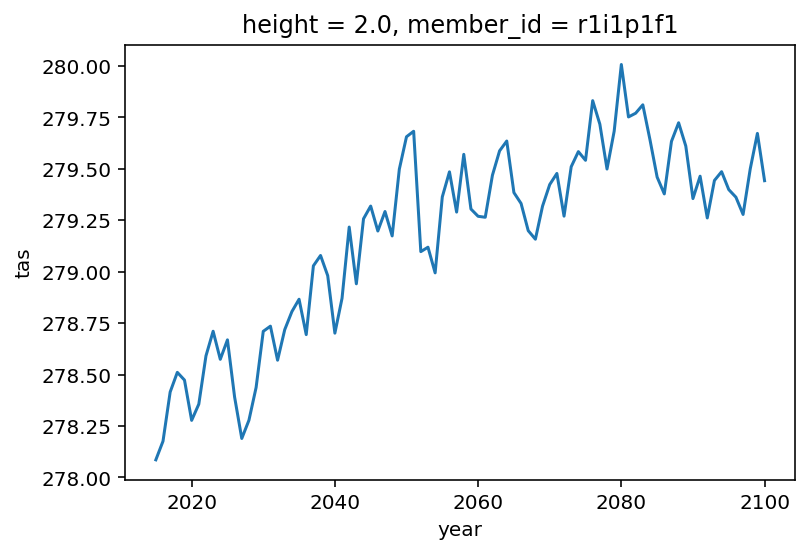

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
_mean.sel(year=slice(2015,2100)).plot()

In [23]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds
                 if (('bounds') in vname ) or ('bnds') in vname]
    return ds.drop(drop_vars)

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    return (ds*weight).mean(dim=('lon', 'lat'))


In [24]:
expt_da = xr.DataArray(expts, dims='experiment', name='experiment',
                       coords={'experiment': expts})

In [25]:
expt_da

<xarray.DataArray 'experiment' (experiment: 4)>
array(['historical', 'ssp126', 'ssp245', 'ssp585'], dtype='<U10')
Coordinates:
  * experiment  (experiment) <U10 'historical' 'ssp126' 'ssp245' 'ssp585'

In [26]:
from collections import defaultdict
dsets_dict = defaultdict(dict)

from tqdm.autonotebook import tqdm

for key, ds in tqdm(dsets.items()):
    attrs = key.split('.')
    source_id = attrs[2]
    experiment_id = attrs[3]
    print(key)
    dsets_dict[source_id][experiment_id] = ds #.tas.groupby('time.year').mean() #.mean(dim=('lat', 'lon'))
    

ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp245.Amon.gn
ScenarioMIP.THU.CIESM.ssp245.Amon.gr
ScenarioMIP.NOAA-GFDL.GFDL-ESM4.ssp126.Amon.gr1
ScenarioMIP.NOAA-GFDL.GFDL-ESM4.ssp585.Amon.gr1
CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.Amon.gn
CMIP.CMCC.CMCC-CM2-SR5.historical.Amon.gn
CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr
ScenarioMIP.INM.INM-CM4-8.ssp245.Amon.gr1
ScenarioMIP.INM.INM-CM4-8.ssp126.Amon.gr1
ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp245.Amon.gn
ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp126.Amon.gr
ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp245.Amon.gn
CMIP.CSIRO.ACCESS-ESM1-5.historical.Amon.gn
ScenarioMIP.KIOST.KIOST-ESM.ssp126.Amon.gr1
ScenarioMIP.CAMS.CAMS-CSM1-0.ssp126.Amon.gn
ScenarioMIP.KIOST.KIOST-ESM.ssp245.Amon.gr1
ScenarioMIP.CCCR-IITM.IITM-ESM.ssp245.Amon.gn
ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp245.Amon.gr
ScenarioMIP.INM.INM-CM5-0.ssp585.Amon.gr1
ScenarioMIP.BCC.BCC-CSM2-MR.ssp245.Amon.gn
ScenarioMIP.NCAR.CESM2-WACCM.ssp126.Amon.gn
CMIP.CCCR-IITM.IITM-ESM.historical.Amon.gn
CMIP.CCCma.CanESM5.histo

In [27]:
dsets_dict['CIESM']['ssp245'].time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    height   float64 ...
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

In [28]:
dsets_dict['ACCESS-ESM1-5']['ssp245'].time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeProlepticGregorian(2015, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(2015, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(2015, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeProlepticGregorian(2100, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(2100, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(2100, 12, 16, 12, 0, 0, 0)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    height   float64 ...
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

In [29]:
from cftime import datetime as dt

expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_dict.items()):
    print(k)
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds.coords['time'] = [dt(date.year, date.month, 15) for date in ds.time.values]
    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_global_mean = [v[expt].pipe(global_mean)
                      for expt in expts]

    # align everything with the 4xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_global_mean, join='outer',
                                 dim=expt_da)

ACCESS-ESM1-5
CIESM
GFDL-ESM4
ACCESS-CM2
CMCC-CM2-SR5
IPSL-CM6A-LR
INM-CM4-8
MPI-ESM1-2-LR
KACE-1-0-G
KIOST-ESM
CAMS-CSM1-0
IITM-ESM
INM-CM5-0
BCC-CSM2-MR
CESM2-WACCM
CanESM5
MIROC6
MRI-ESM2-0
FIO-ESM-2-0
NorESM2-MM
FGOALS-g3
MPI-ESM1-2-HR
EC-Earth3
NESM3
AWI-CM-1-1-MR
FGOALS-f3-L
NorESM2-LM
EC-Earth3-Veg



In [30]:
dsets_aligned['MPI-ESM1-2-LR']

<xarray.Dataset>
Dimensions:        (experiment_id: 4, member_id: 1, time: 3012)
Coordinates:
  * experiment_id  (experiment_id) <U10 'historical' 'ssp126' 'ssp245' 'ssp585'
  * time           (time) object 1850-01-15 00:00:00 ... 2100-12-15 00:00:00
    height         float64 2.0
  * member_id      (member_id) <U8 'r1i1p1f1'
Data variables:
    tas            (experiment_id, member_id, time) float64 284.6 ... 289.4

In [31]:
with progress.ProgressBar():
    dsets_aligned_ = dask.compute(dsets_aligned)[0]

In [32]:
dsets_aligned_.keys()

dict_keys(['ACCESS-ESM1-5', 'CIESM', 'GFDL-ESM4', 'ACCESS-CM2', 'CMCC-CM2-SR5', 'IPSL-CM6A-LR', 'INM-CM4-8', 'MPI-ESM1-2-LR', 'KACE-1-0-G', 'KIOST-ESM', 'CAMS-CSM1-0', 'IITM-ESM', 'INM-CM5-0', 'BCC-CSM2-MR', 'CESM2-WACCM', 'CanESM5', 'MIROC6', 'MRI-ESM2-0', 'FIO-ESM-2-0', 'NorESM2-MM', 'FGOALS-g3', 'MPI-ESM1-2-HR', 'EC-Earth3', 'NESM3', 'AWI-CM-1-1-MR', 'FGOALS-f3-L', 'NorESM2-LM', 'EC-Earth3-Veg'])

In [33]:
models = list(dsets_aligned_.keys())
model_da = xr.DataArray(models, dims='model', name='model',
                         coords={'model': models})

big_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                    dim=model_da)

big_ds

<xarray.Dataset>
Dimensions:        (experiment_id: 4, member_id: 1, model: 28, time: 5412)
Coordinates:
  * model          (model) <U13 'ACCESS-ESM1-5' 'CIESM' ... 'EC-Earth3-Veg'
  * time           (time) object 1850-01-15 00:00:00 ... 2300-12-15 00:00:00
  * experiment_id  (experiment_id) <U10 'historical' 'ssp126' 'ssp245' 'ssp585'
  * member_id      (member_id) <U8 'r1i1p1f1'
Data variables:
    tas            (model, experiment_id, member_id, time) float64 285.9 ... nan

In [34]:
big_ds.tas.time

<xarray.DataArray 'time' (time: 5412)>
array([cftime.datetime(1850, 1, 15, 0, 0, 0, 0),
       cftime.datetime(1850, 2, 15, 0, 0, 0, 0),
       cftime.datetime(1850, 3, 15, 0, 0, 0, 0), ...,
       cftime.datetime(2300, 10, 15, 0, 0, 0, 0),
       cftime.datetime(2300, 11, 15, 0, 0, 0, 0),
       cftime.datetime(2300, 12, 15, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1850-01-15 00:00:00 ... 2300-12-15 00:00:00

In [35]:
annual_mean = big_ds.groupby('time.year').mean()

In [41]:
annual_mean

<xarray.Dataset>
Dimensions:        (experiment_id: 4, member_id: 1, model: 28, year: 451)
Coordinates:
  * model          (model) <U13 'ACCESS-ESM1-5' 'CIESM' ... 'EC-Earth3-Veg'
  * experiment_id  (experiment_id) <U10 'historical' 'ssp126' 'ssp245' 'ssp585'
  * member_id      (member_id) <U8 'r1i1p1f1'
  * year           (year) int64 1850 1851 1852 1853 1854 ... 2297 2298 2299 2300
Data variables:
    tas            (year, model, experiment_id, member_id) float64 287.8 ... nan

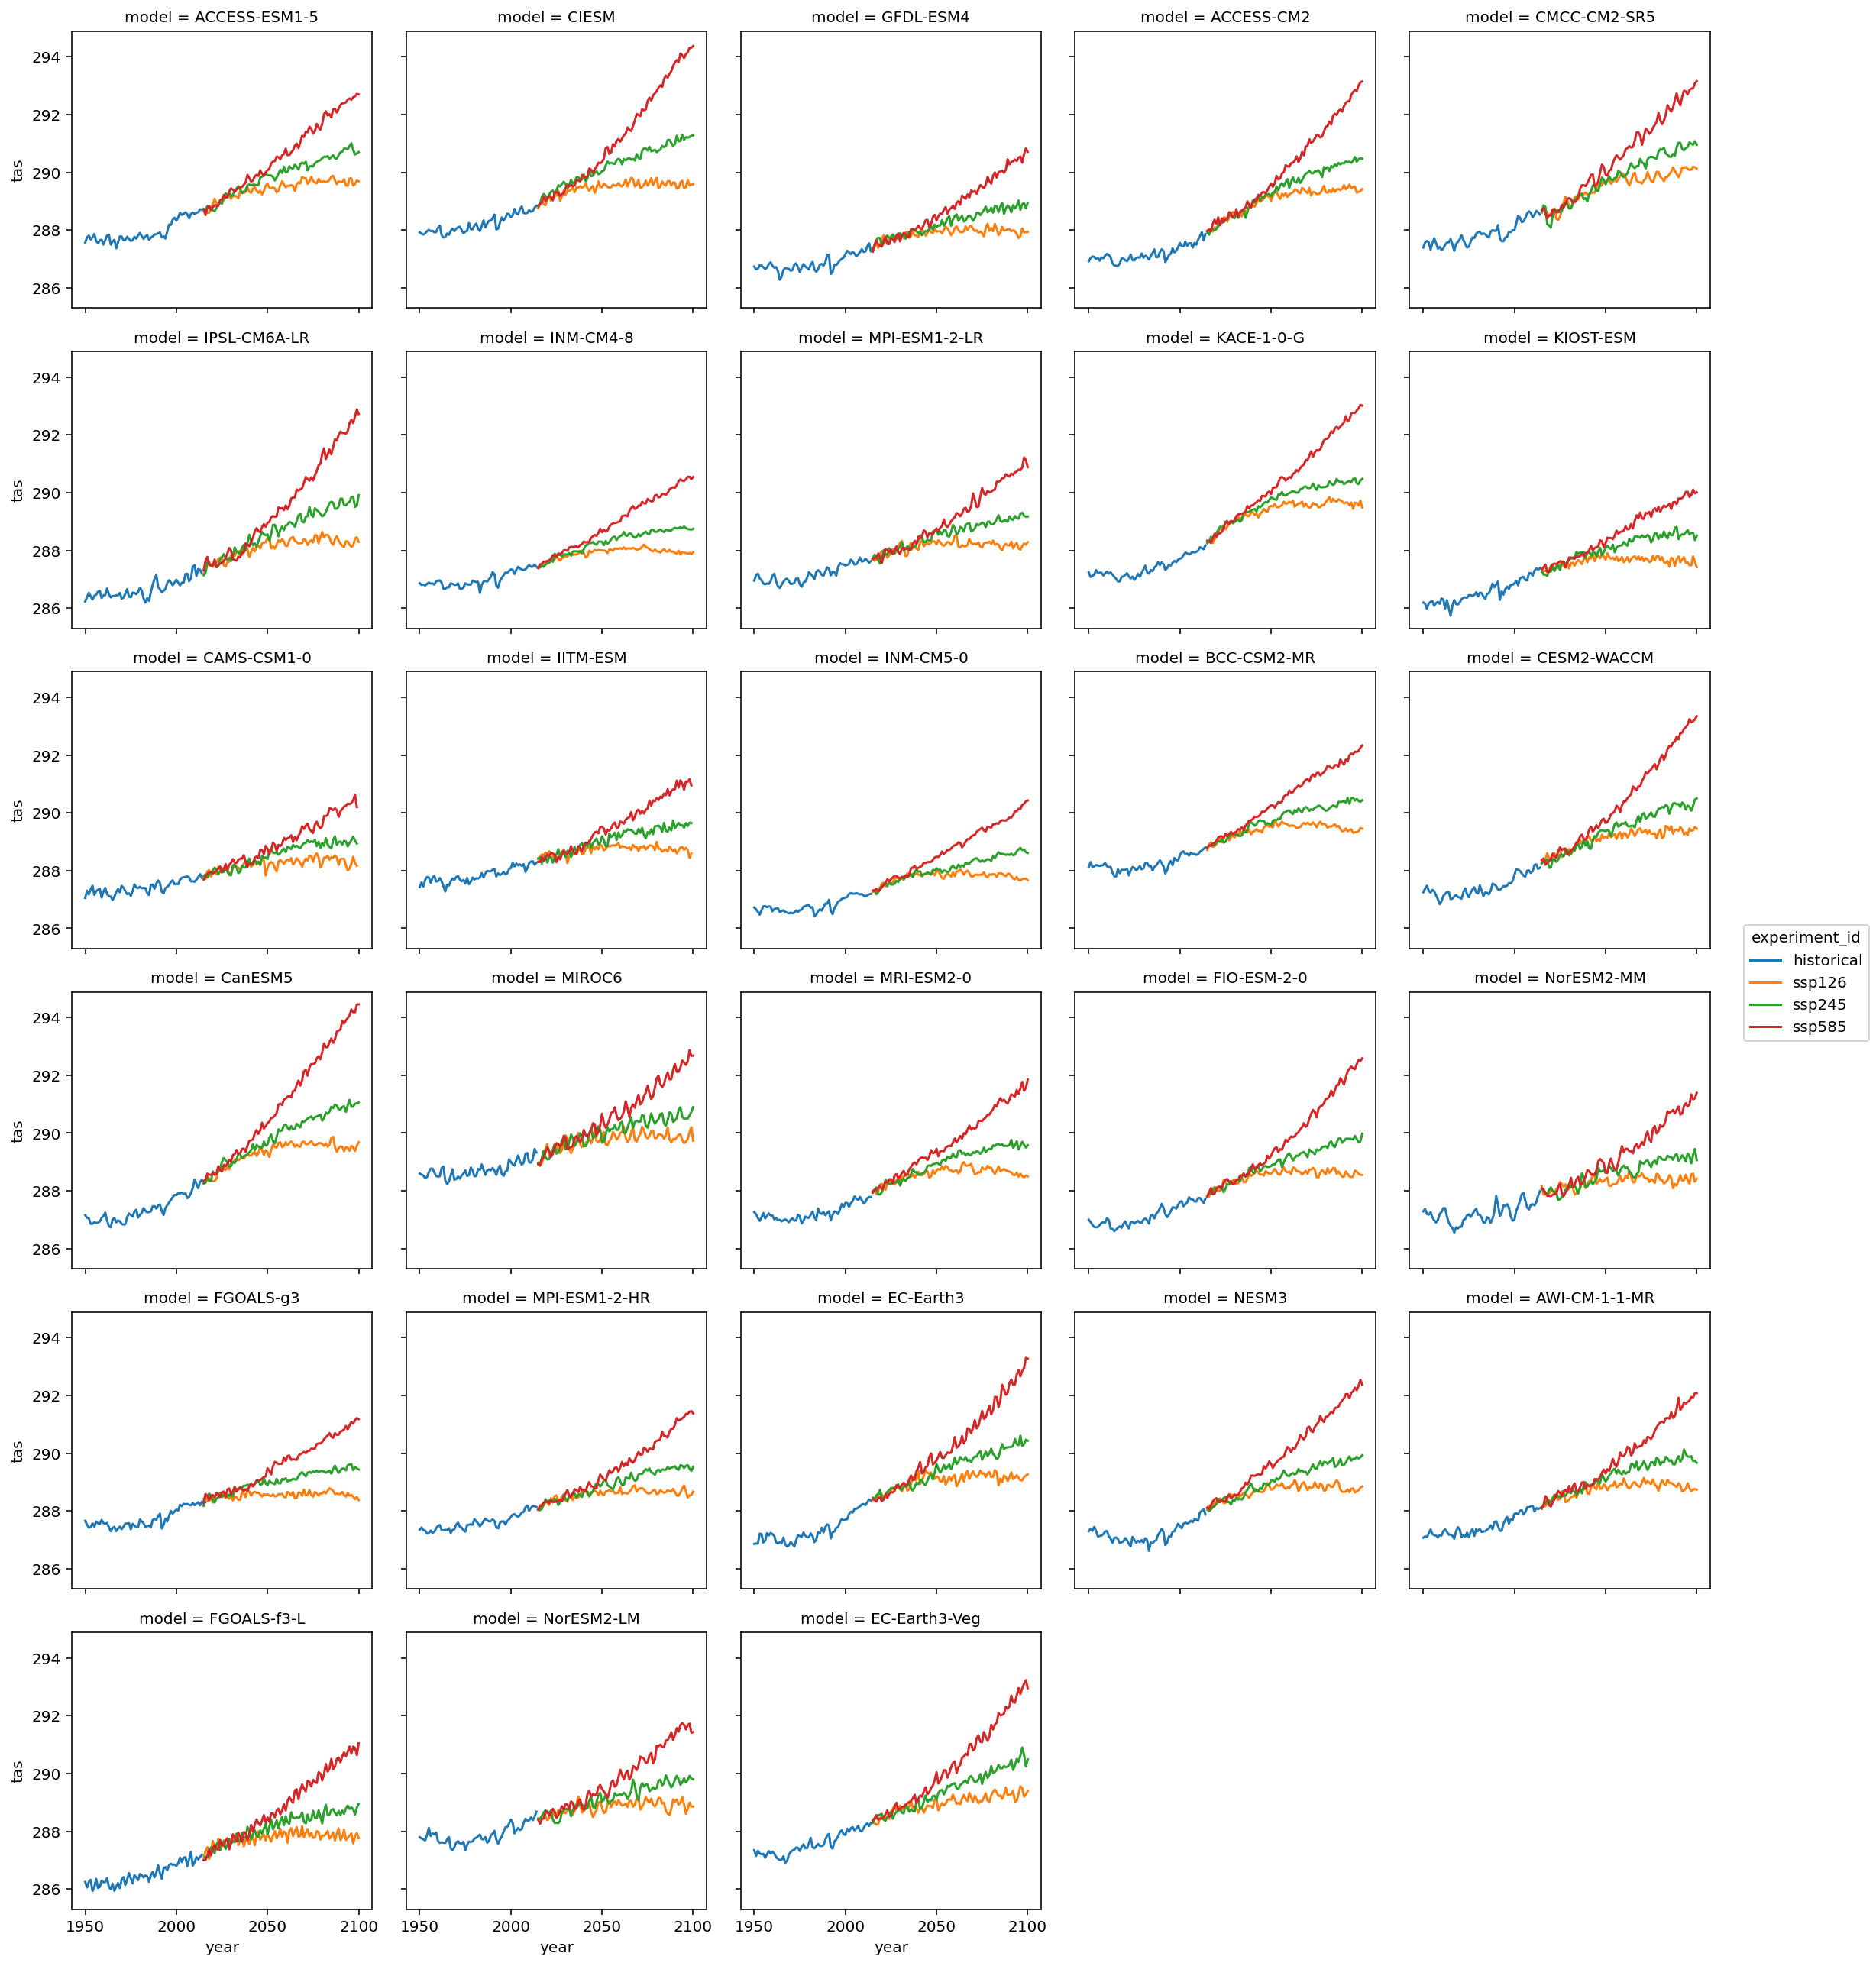

In [51]:
# create a line plot for each model id!
#import hvplot.xarray 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#annual_mean.drop('member_id')
annual_mean.tas.sel(year=slice(1950,2100)).plot(col='model', x='year', hue='experiment_id', col_wrap=5)

In [47]:
df_all = annual_mean.sel(year=slice(1950, 2100)).to_dataframe().reset_index()
df_all.head()

,experiment_id,member_id,model,year,tas
0,historical,r1i1p1f1,ACCESS-ESM1-5,1950,287.568669
1,historical,r1i1p1f1,ACCESS-ESM1-5,1951,287.751496
2,historical,r1i1p1f1,ACCESS-ESM1-5,1952,287.812061
3,historical,r1i1p1f1,ACCESS-ESM1-5,1953,287.677066
4,historical,r1i1p1f1,ACCESS-ESM1-5,1954,287.753777


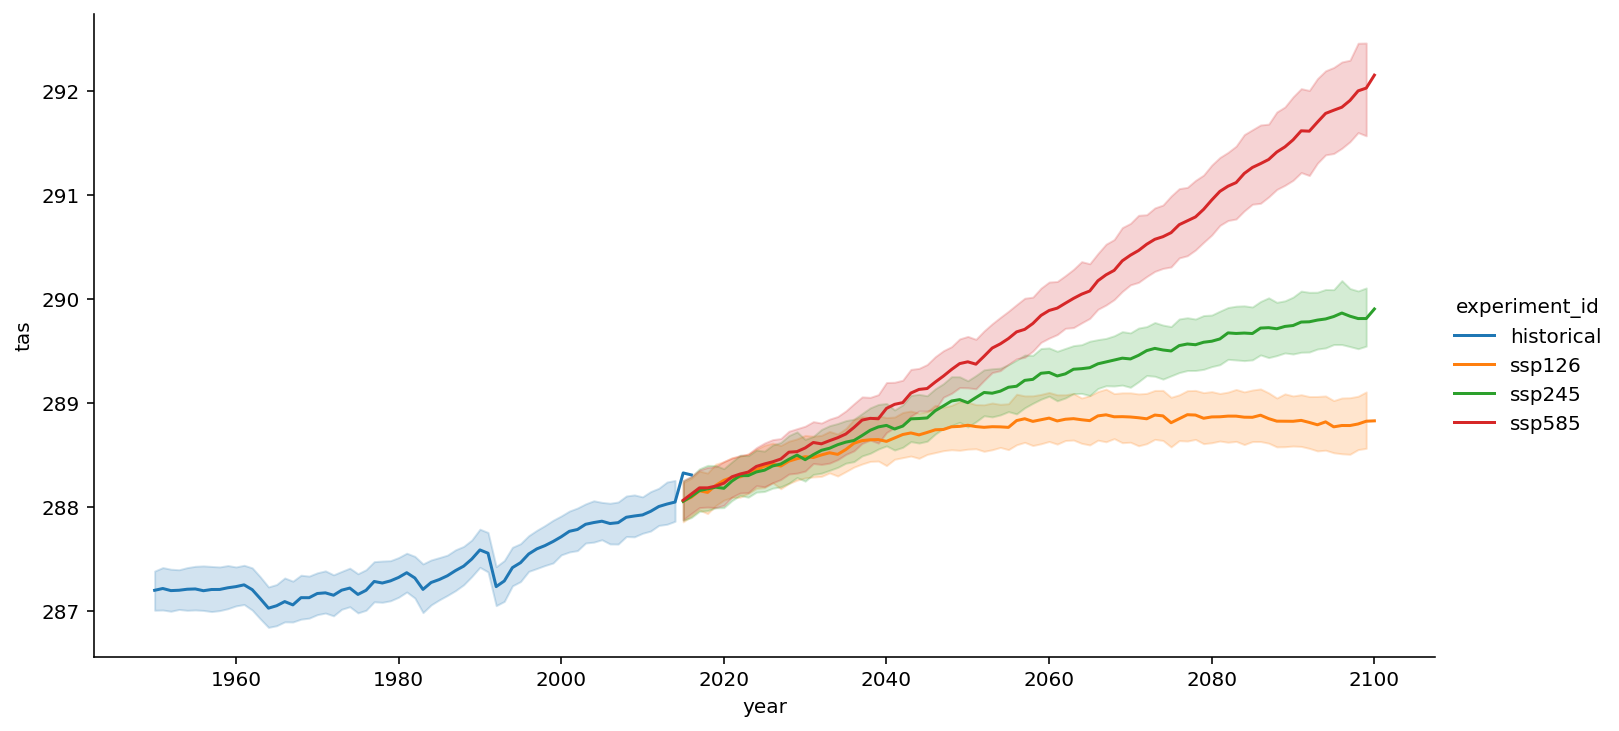

In [52]:
sns.relplot(data=df_all,
            x="year", y="tas", hue='experiment_id',
            kind="line", aspect=2);